# Parkinsons Disease Detection with FBANKs and xvectors

using: 
- Adam optimizer with linear schedular.
- Global normalization; computes a single normalization vector for all the dataset
- Negative LogLikelihood loss.

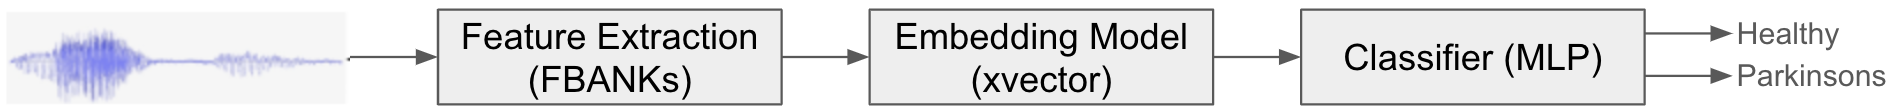


## Hyperparameter File

In [27]:
%%file hparams_xvector_fbanks.yaml

# Your code here
# #################################
# Basic training parameters for digit classification with Xvector
#
# Author:
#  * Mirco Ravanelli 2021
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/Xvector/FBANKs/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train-check.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid-check.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test-check.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 25
batch_size: 16
lr_start: 0.001
lr_final: 0.0001
n_classes: 2
emb_dim: 128 # dimensionality of the embeddings
dataloader_options:
    batch_size: !ref <batch_size>

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Embedding model: from variable size recordings gets a fixed size embedding vector
embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 5
    tdnn_channels: [64, 64, 64, 64, 128]
    tdnn_kernel_sizes: [5, 3, 3, 1, 1]
    tdnn_dilations: [1, 2, 3, 1, 1]
    lin_neurons: !ref <emb_dim>

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <emb_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <emb_dim>
    out_neurons: !ref <n_classes>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model: !ref <embedding_model>
    classifier: !ref <classifier>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>


Overwriting hparams_xvector_fbanks.yaml


In [42]:
%%file train_xvector_fbanks.py
# Your code here

#!/usr/bin/env python3
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from sklearn.metrics import confusion_matrix
from confusion_matrix_fig import create_cm_fig
import numpy as np


# Brain class for speech enhancement training
class DetectorBrain(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Runs all the computations that transforms the input into the
        output probabilities over the N classes.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        predictions : Tensor
            Tensor that contains the posterior probabilities over the N classes.
        """
        # Your code here. Aim for 7-8 lines
        batch = batch.to(self.device)

        # Feature extraction and normalization
        wavs, lens = batch.sig
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm(feats, lens)

        embeddings = self.modules.embedding_model(feats, lens)
        predictions = self.modules.classifier(embeddings)
        predictions = self.hparams.log_softmax(predictions)

        return predictions


    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : tensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        # Your code here. Aim for 7-8 lines
        _, lens = batch.sig
        detection_id, _ = batch.detection_id_encoded

        # Compute the cost function
        loss = sb.nnet.losses.nll_loss(predictions, detection_id, lens)

        # Append this batch of losses to the loss metric for easy
        self.loss_metric.append(
            batch.id, predictions, detection_id, lens, reduction="batch"
        )

        # Compute classification error at test time
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, detection_id, lens)

        # Confusion matrices
        if stage != sb.Stage.TRAIN:
            y_true = detection_id.cpu().detach().numpy().squeeze(-1)
            y_pred = predictions.cpu().detach().numpy().argmax(-1).squeeze(-1)

        # if stage == sb.Stage.VALID:
        #     confusion_matix = confusion_matrix(
        #         y_true,
        #         y_pred,
        #         labels=sorted(self.hparams.label_encoder.ind2lab.keys()),
        #     )
        #     self.valid_confusion_matrix += confusion_matix
        if stage == sb.Stage.TEST:
            confusion_matix = confusion_matrix(
                y_true,
                y_pred,
                labels=sorted(self.hparams.label_encoder.ind2lab.keys()),
            )
            self.test_confusion_matrix += confusion_matix

        # Compute accuracy using MetricStats
        self.acc_metric.append(
            batch.id, predict=predictions, target=detection_id, lengths=lens
        )

        return loss


    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Compute accuracy using MetricStats
        # Define function taking (prediction, target, length) for eval
        def accuracy_value(predict, target, lengths):
            """Computes accuracy."""
            nbr_correct, nbr_total = sb.utils.Accuracy.Accuracy(
                predict, target, lengths
            )
            acc = torch.tensor([nbr_correct / nbr_total])
            return acc

        self.acc_metric = sb.utils.metric_stats.MetricStats(
            metric=accuracy_value, n_jobs=1
        )

        # Confusion matrices
        # if stage == sb.Stage.VALID:
        #     self.valid_confusion_matrix = np.zeros(
        #         shape=(self.hparams.n_classes, self.hparams.n_classes),
        #         dtype=int,
        #     )
        if stage == sb.Stage.TEST:
            self.test_confusion_matrix = np.zeros(
                shape=(self.hparams.n_classes, self.hparams.n_classes),
                dtype=int,
            )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss
            self.train_stats = {
                "loss": self.train_loss,
                "acc": self.acc_metric.summarize("average"),
            }

        # Summarize the statistics from the stage for record-keeping.
        elif stage == sb.Stage.VALID:
            valid_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }
        # Summarize Test statistics from the stage for record-keeping
        else:
            test_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # Tensorboard logging
            if self.hparams.use_tensorboard:
                self.hparams.tensorboard_train_logger.log_stats(
                    stats_meta={"Epoch": epoch},
                    train_stats=self.train_stats,
                    valid_stats=valid_stats,
                )
                # Log confusion matrix fig to tensorboard
                # cm_fig = create_cm_fig(
                #     self.valid_confusion_matrix,
                #     display_labels=list(
                #         self.hparams.label_encoder.ind2lab.values()
                #     ),
                # )
                # self.hparams.tensorboard_train_logger.writer.add_figure(
                #     "Validation Confusion Matrix", cm_fig, epoch
                # )

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=valid_stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=valid_stats, min_keys=["error"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            # self.hparams.train_logger.log_stats(
            #     {"Epoch loaded": self.hparams.epoch_counter.current},
            #     test_stats=stats,
            # )
            # Per class accuracy from Test confusion matrix
            per_class_acc_arr = np.diag(self.test_confusion_matrix) / np.sum(
                self.test_confusion_matrix, axis=1
            )
            per_class_acc_arr_str = "\n" + "\n".join(
                "{:}: {:.3f}".format(class_id, class_acc)
                for class_id, class_acc in enumerate(per_class_acc_arr)
            )

            self.hparams.train_logger.log_stats(
                {
                    "Epoch loaded": self.hparams.epoch_counter.current,
                    "\n Per Class Accuracy": per_class_acc_arr_str,
                    "\n Confusion Matrix": "\n{:}\n".format(
                        self.test_confusion_matrix
                    ),
                },
                test_stats=test_stats,
            )


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.
    We expect `prepare_mini_librispeech` to have been called before this,
    so that the `train.json`, `valid.json`,  and `valid.json` manifest files
    are available.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Initialization of the label encoder. The label encoder assigns to each
    # of the observed label a unique index (e.g, 'digit0': 0, 'digit1': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig, fs = torchaudio.load(wav)

        # Resampling
        # print('input signal(s) shape: ', sig.squeeze().shape)
        sig = torchaudio.functional.resample(sig.squeeze(0), fs, hparams["sample_rate"]) # Your code here. Aim for 1-2 lines
        return sig

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("detection")
    @sb.utils.data_pipeline.provides("detection", "detection_id_encoded")
    def label_pipeline(detection_id):
        """Defines the pipeline to process the detection labels.
        Note that we have to assign a different integer to each class
        through the label encoder.
        """
        yield detection_id
        detection_id_encoded = label_encoder.encode_label_torch(detection_id)
        yield detection_id_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    hparams["dataloader_options"]["shuffle"] = True
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "detection_id_encoded"],
        )

    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mapping.
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="detection",
    )

    return datasets, label_encoder


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin,  overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Tensorboard logging
    if hparams["use_tensorboard"]:
        from speechbrain.utils.train_logger import TensorboardLogger

        hparams["tensorboard_train_logger"] = TensorboardLogger(
            hparams["tensorboard_logs_folder"]
        )

    # Create dataset objects "train", "valid", and "test".
    datasets, label_encoder = dataio_prep(hparams)
    
    hparams["label_encoder"] = label_encoder
    class_labels = sorted(list(label_encoder.ind2lab.values()))
    print("Class Labels:", class_labels, list(label_encoder.lab2ind.values()))

    # Initialize the Brain object to prepare for mask training.
    detection_brain = DetectorBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    detection_brain.fit(
        epoch_counter=detection_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = detection_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["dataloader_options"],
    )



Overwriting train_xvector_fbanks.py


In [43]:
# Delete the output folder to start training from scratch
# (and not from a previous checkpoint).
!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/Xvector/FBANKs/1986

import sys
# Run Training
!{sys.executable} train_xvector_fbanks.py hparams_xvector_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=25 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/Xvector/FBANKs/1986
2025-04-02 19:24:36.233468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 19:24:36.256379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] 

In [2]:
!pip show speechbrain

In [1]:
import speechbrain as sb

In [4]:
import sys
print(sys.executable)


/home/ulaval.ca/maelr5/parkinsons/parksenv/bin/python


In [5]:
!{sys.executable} -m pip show speechbrain


Name: speechbrain
Version: 1.0.2
Summary: All-in-one speech toolkit in pure Python and Pytorch
Home-page: https://speechbrain.github.io/
Author: Mirco Ravanelli, Titouan Parcollet & Others
Author-email: speechbrain@gmail.com
License: 
Location: /home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages
Requires: huggingface_hub, hyperpyyaml, joblib, numpy, packaging, scipy, sentencepiece, torch, torchaudio, tqdm
Required-by: 
